# Fairness Benchmark

This notebook plots the suboptimality performance of various optimization algorithms against demographic/statistical parity on the Diabetes 130-Hospitals (`diabetes`) and Adult Census (`acsincome`) benchmarks.

In [38]:
import os
import sys
import pickle
import pandas as pd
import numpy as np
import torch
from torch.nn.functional import binary_cross_entropy_with_logits
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("..")
from src.utils.io import get_path, var_to_str, load_results
from src.utils.data import load_dataset

from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, equalized_odds_difference, equalized_odds_ratio
from tqdm import tqdm

In [39]:

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

In [40]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['xtick.labelsize'] = 26
mpl.rcParams['ytick.labelsize'] = 26
mpl.rcParams["axes.labelsize"] = 34
mpl.rcParams['legend.fontsize'] = 32
mpl.rcParams['axes.titlesize'] = 32
mpl.rcParams['text.usetex'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [41]:
l2_reg = 1.0
shift_cost = 1.0
result_dir = "../results"
base = "/home/hp/pai/check1/prospect/experiments/results"
# base_dir = "/home/hp/pai/check1/prospect/experiments/results_4.000000_512/"

In [42]:
plot_cfgs = [
    {
        "optimizer": "sgd",
        "label": "SGD",
        "color": "black",
        "linestyle": "solid",
        "marker": ".",
        "epsilon":4,
        # "batch_size":512,
    },
    {
        "optimizer": "dp_sgd",
        "label": "DP-SGD eps=2",
        "color": "yellow",
        "linestyle": "solid",
        "marker": "^",
        "epsilon":2,
        # "batch_size":512,
    },
    {
        "optimizer": "dp_sgd",
        "label": "DP-SGD eps=4",
        "color": "tab:red",
        "linestyle": "solid",
        "marker": "^",
        "epsilon":4,
        # "batch_size":512,
    },

    {
        "optimizer": "dp_sgd",
        "label": "DP-SGD eps=8",
        "color": "blue",
        "linestyle": "solid",
        "marker": "^",
        "epsilon":8,
        # "batch_size":512,
    },
    {
        "optimizer": "dp_sgd",
        "label": "DP-SGD eps=16",
        "color": "green",
        "linestyle": "solid",
        "marker": "^",
        "epsilon":16,
        # "batch_size":512,
    },
        {
        "optimizer": "dp_sgd",
        "label": "DP-SGD eps=1024",
        "color": "pink",
        "linestyle": "solid",
        "marker": "^",
        "epsilon":1024,
        # "batch_size":512,
    },
    # {
    #     "optimizer": "saddlesaga",
    #     "label": "SaddleSAGA",
    #     "color": "goldenrod",
    #     "linestyle": "solid",
    #     "marker": "s",
    # },
    # {
    #     "optimizer": "lsvrg",
    #     "label": "LSVRG",
    #     "color": "cadetblue",
    #     "linestyle": "solid",
    #     "marker": "o",
    #     "epsilon":4,
    #     "batch_size":512,
    # },
    # {
    #     "optimizer": "prospect",
    #     "label": "Prospect (Ours)",
    #     "color": "tab:red",
    #     "linestyle": "solid",
    #     "marker": "^",
    # },
]

In [43]:
# epsilon = 4
# batch_size = 512

In [44]:
def get_mypath(base_dir,model_cfg,datset,specific_cfg):
    path1 = get_path([datset,var_to_str(model_cfg),var_to_str(specific_cfg)],base_dir)
    return path1

def get_mypath2(base_dir,model_cfg,datset):
    path1 = get_path([datset,var_to_str(model_cfg)],base_dir)
    return path1


In [45]:
def get_suboptimality(
    dataset, model_cfg, train_loss, eps=1e-9, out_path="../results/"
):
    init_loss = train_loss[0]
    path = get_path([dataset, var_to_str(model_cfg)], out_path=out_path)
    f = os.path.join(path, "lbfgs_min_loss.p")
    min_loss = pickle.load(open(f, "rb"))
    subopt = (train_loss - min_loss + eps) / (init_loss - min_loss)
    return subopt


    
def get_iterates(dataset,objective  ,optimizer, seed=1, result_dir=None):
    loss = "squared_error" if dataset == "acsincome" else "binary_cross_entropy"
    model_cfg = {
        "objective": objective,
        "l2_reg": l2_reg,
        "loss": loss,
        # "n_class": None,
        "shift_cost": shift_cost
    }
    best_path = get_mypath2(result_dir,model_cfg=model_cfg,datset=dataset)
    best_path = os.path.join(best_path,optimizer+"/best_cfg.p")
    specific_cfg = None
    with open(best_path, 'rb') as file:
        specific_cfg = pickle.load(file)
    print("objective",objective,"specific_cfg",specific_cfg)
    path = get_mypath(datset=dataset,model_cfg=model_cfg,base_dir=result_dir,specific_cfg=specific_cfg)
    f = os.path.join(path, f"seed_{seed}.p")
    data = pickle.load(open(f, "rb"))
    metrics_data = data['metrics']    
    return metrics_data['weights']


def get_dp(X,y,dataset,column, objective,optimizer, metric="difference",df=None,base_dir=None):
    iterates = get_iterates(dataset=dataset,objective=objective, optimizer=optimizer,result_dir=base_dir)
    out = []
    for i, w in tqdm(enumerate(iterates)):
        if i>=0:
            y_pred = (X @ w >= 0).int()
            if metric == "difference":
                out.append(demographic_parity_difference(y, y_pred, sensitive_features=list(df[column])))
            elif metric == "ratio":
                out.append(demographic_parity_ratio(y, y_pred, sensitive_features=list(df[column])))
    return out



def get_ks_dist(y_pred, y_true):
    out = ks_2samp(y_pred, y_true, method="asymp")
    return out.statistic

def get_dist_groups(X,df,column, optimizer, objective, dataset="acsincome", method="ks",base_dir=None):
    iterates = get_iterates(dataset=dataset,objective=objective, optimizer=optimizer,result_dir=base_dir)
    # print(iterates)
    # print()
    # return
    groups = list(df[column].unique())

    dist_groups = []

    for i, w in tqdm(enumerate(iterates)):
        # print("w.shape",w.shape)
        # y_pred = (X @ w).numpy()
        if i>0:
            y_pred = (X @ w).detach().numpy()
            ypd = pd.Series(y_pred)
            y_groups = [(ypd.loc[df[column] == group]).to_numpy() for group in groups]
            if method == "ks":
                dist_groups.append(np.array([get_ks_dist(y_pred, y_group) for y_group in y_groups]))
            elif method == "wasserstein":
                raise Exception("Wasserstein not defined!")
            #     dist_groups.append(np.array([wasserstein_dist(y_pred, y_group) for y_group in y_groups]))

    return np.array(dist_groups)

def plot_ax(ax, seeds, objective, plot_cfg, dataset, epoch_len=None, n=4000, downsample=1, max_epoch=32, markersize=8, out_path="../results/"):
    optimizer = plot_cfg['optimizer']
    model_cfg = {
        "objective": objective, 
        "l2_reg": l2_reg, 
        "loss": "binary_cross_entropy" if dataset == "diabetes" else "squared_error", 
        "n_class": None,
        "shift_cost": shift_cost
    }
    for seed in seeds:
        filename = plot_cfg["optimizer"]
        path = get_path([dataset, var_to_str(model_cfg), filename], out_path=out_path)
        df = pickle.load(open(os.path.join(path, "best_traj.p"), "rb"))
        train_loss = torch.tensor(df["average_train_loss"])
        epochs = torch.arange(len(train_loss))
        subopt = get_suboptimality(
            dataset, model_cfg, train_loss, out_path=result_dir
        )
        if optimizer == "lsvrg":
            x = epochs * 2
        elif optimizer in ["sgd", "srda"]:
            x = epochs
        else:
            x = epochs
        idx = (x <= max_epoch)
        ax.plot(
            x[idx][::downsample], 
            subopt[idx][::downsample], 
            label=plot_cfg['label'], 
            color=plot_cfg['color'],
            marker=plot_cfg['marker'],
            markersize=markersize
        )

objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:03, 34.53it/s]


sp mean sgd 0.03222155710273951
sp std sgd 0.0037560400345592318
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:04, 31.80it/s]


sp mean dp_sgd 0.032561035872259565
sp std dp_sgd 0.023770789746139453
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:04, 31.00it/s]


sp mean dp_sgd 0.04635271241528095
sp std dp_sgd 0.01603700839341622
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:03, 34.64it/s]


sp mean dp_sgd 0.0238587286218769
sp std dp_sgd 0.012741883496937069
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:04, 31.25it/s]


sp mean dp_sgd 0.01966084263049846
sp std dp_sgd 0.01569002173181597
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:04, 31.88it/s]


sp mean dp_sgd 0.020438228925198178
sp std dp_sgd 0.010657539326915228
objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:03, 32.49it/s]


sp mean sgd 0.03222155710273951
sp std sgd 0.0037560400345592318
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:04, 28.97it/s]


sp mean dp_sgd 0.0318808730831502
sp std dp_sgd 0.02021611675027507
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:03, 32.83it/s]


sp mean dp_sgd 0.03197126683834784
sp std dp_sgd 0.01775579276248545
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:04, 31.12it/s]


sp mean dp_sgd 0.0398994017942156
sp std dp_sgd 0.010999378465805608
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:03, 32.33it/s]


sp mean dp_sgd 0.03080498652128672
sp std dp_sgd 0.0103343497860543
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:03, 33.51it/s]


sp mean dp_sgd 0.018863368834643707
sp std dp_sgd 0.005517842284751242
torch.Size([1000, 202])
torch.Size([1000])
[1. 2.]
[1. 2. 9. 8. 7. 6. 5. 3.]
objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:00, 218.70it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:00, 153.59it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:00, 255.47it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:00, 152.62it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:00, 269.96it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:00, 162.86it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:00, 165.69it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:00, 170.45it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:00, 197.36it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:00, 230.39it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:00, 297.12it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:00, 234.24it/s]


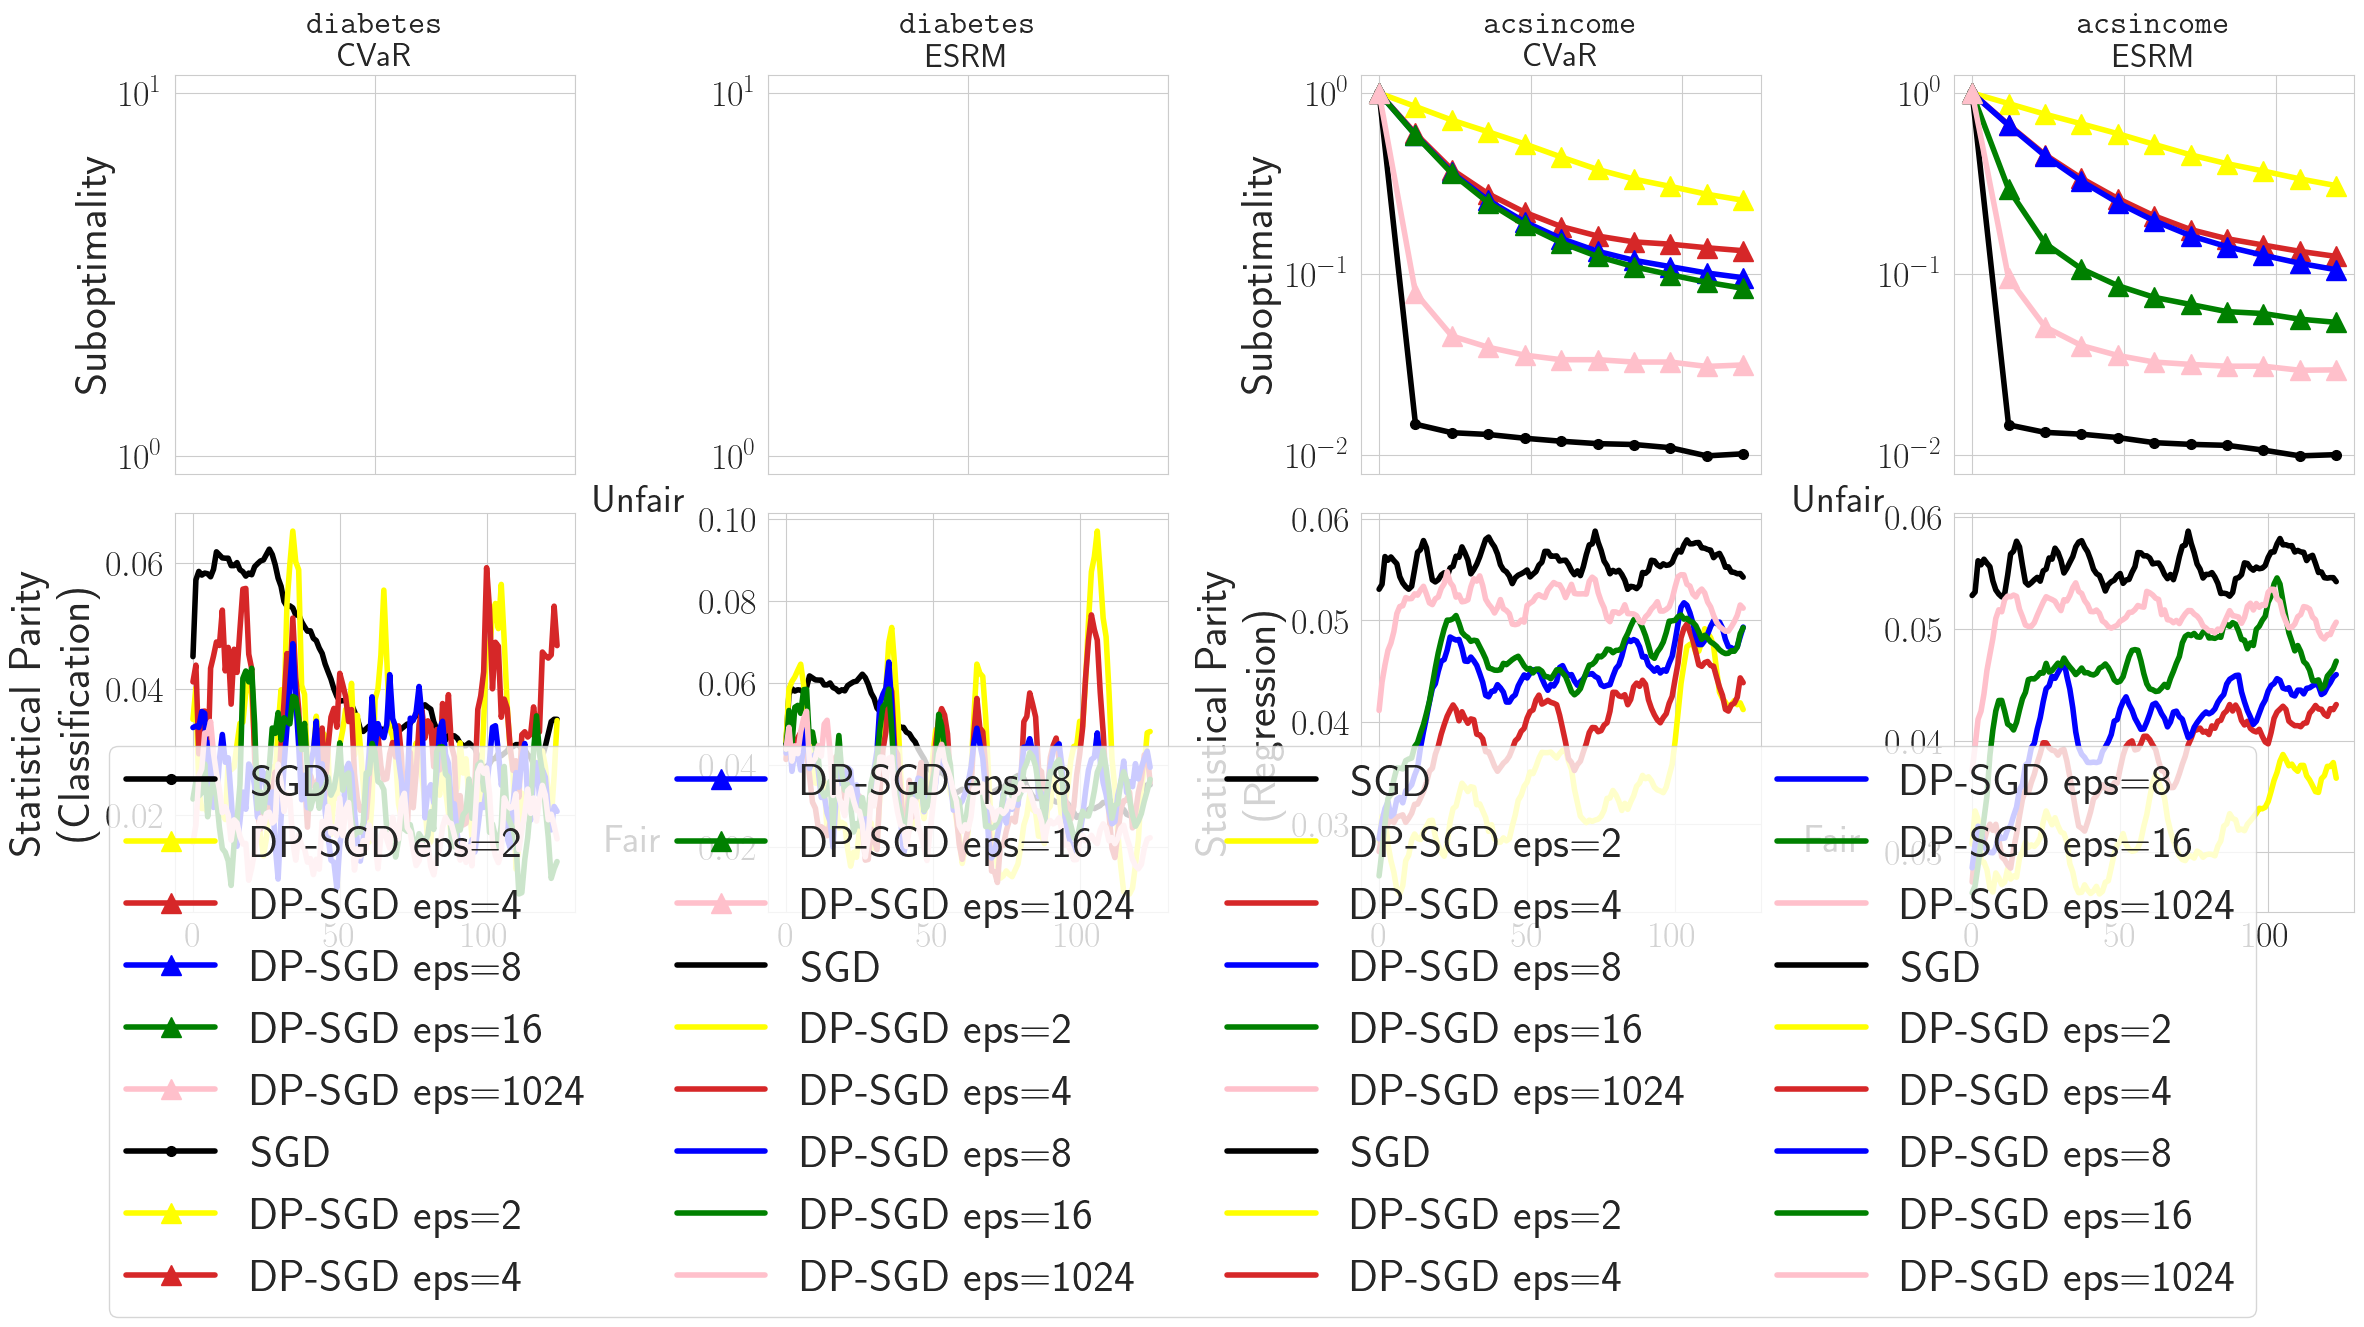

In [49]:
## demographic parity
from sklearn.preprocessing import LabelEncoder
dataset = "diabetes"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()

# print(X.shape)
# print(y.shape)

df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")
# print(df.gender.unique())
# print(df.race.unique())
# print(df.head)
# sex_tensor = torch.tensor(pd.get_dummies(df["gender"]).values, dtype=torch.float64)
# rac1p_tensor = torch.tensor(pd.get_dummies(df["race"]).values, dtype=torch.float64)

le_gender = LabelEncoder()
le_race = LabelEncoder()

gender_encoded = le_gender.fit_transform(df["gender"])
race_encoded = le_race.fit_transform(df["race"])

# Convert to tensors
gender_tensor = torch.tensor(gender_encoded, dtype=torch.float64).unsqueeze(1)
race_tensor = torch.tensor(race_encoded, dtype=torch.float64).unsqueeze(1)

# Concatenate the new attributes to X
X1 = torch.cat((X, gender_tensor, race_tensor), dim=1)

objectives = ["superquantile", "esrm"]
column = "gender"
metric = "difference"

sns.set_style("whitegrid")

fig, ax = plt.subplots(2, len(objectives) * 2, figsize=(12 * len(objectives), 10))

obj_names = ["CVaR", "ESRM", "CVaR", "ESRM"]
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        # print(plot_cfg)
        epsilon = plot_cfg["epsilon"]
        # batch_size = plot_cfg["batch_size"]
        # path = os.path.join(base + f"_{float(epsilon):.6f}_{batch_size}")

        path = os.path.join(base + f"_{float(epsilon):.6f}")
        
        optimizer = plot_cfg["optimizer"]
        yy = get_dp(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, metric=metric,df=df,base_dir=path)
        xx = np.arange(len(yy))

        print(f"sp mean {optimizer}", np.array(yy)[-10:].mean())
        print(f"sp std {optimizer}", np.array(yy)[-10:].std())
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))


        markersize = 14
        downsample = 2
        ax[1, j].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        # ax[1, j].set_xticklabels([])
        ax[0, j].set_title(r"{\texttt{diabetes}}" + f"\n{obj_names[j]}", fontsize=24)

        
        # plot_ax(ax[0, j], [1], objective, plot_cfg, dataset, max_epoch=32, downsample=downsample, markersize=markersize,out_path=path)
        ax[0, j].set_yscale("log")
        ax[0, j].set_xticklabels([])


ax[1, 0].set_ylabel("Statistical Parity\n(Classification)", fontsize=32)
ax[0, 0].set_ylabel(f"Suboptimality", fontsize=32)

# plt.show()
# acsincome

dataset = "acsincome"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()

print(X.shape)
print(y.shape)

df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")
print(df.SEX.unique())
print(df.RAC1P.unique())

objectives = ["superquantile", "esrm", "superquantile", "esrm"]
column = "SEX"
# metric = "ratio"
dataset = "acsincome"

obj_names = ["CVaR", "ESRM", "CVaR", "ESRM"]
for j, objective in enumerate(objectives):
    if j>1:
        for plot_cfg in plot_cfgs:
            epsilon = plot_cfg["epsilon"]
            # batch_size = plot_cfg["batch_size"]
            # path = os.path.join(base + f"_{float(epsilon):.6f}_{batch_size}")       
            path = os.path.join(base + f"_{float(epsilon):.6f}")

            optimizer = plot_cfg["optimizer"]
            group_loss = get_dist_groups(X,df,column, optimizer, objective,base_dir=path)
            yy = np.max(group_loss, axis=1) # worst distance
            xx = np.arange(len(yy))
            window_size = 5  # You can adjust the window size as needed
            yy_moving_avg = moving_average(yy, window_size)
            xx_moving_avg = np.arange(len(yy_moving_avg))

            markersize = 14
            downsample = 6
            ax[1, j].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
            # ax[1, j].set_xticklabels([])
            ax[0, j].set_title(r"{\texttt{acsincome}}" + f"\n{obj_names[j]}", fontsize=24)
            plot_ax(ax[0, j], [1], objective, plot_cfg, dataset, max_epoch=64, downsample=downsample, markersize=markersize,out_path=path)
            ax[0, j].set_yscale("log")
            ax[0, j].set_xticklabels([])


# # arrows
fig.text(0.26, 0.13, "Fair", fontsize=28)
fig.text(0.255, 0.47, "Unfair", fontsize=28)
fig.text(0.76, 0.13, "Fair", fontsize=28)
fig.text(0.755, 0.47, "Unfair", fontsize=28)

ax[1, 2].set_ylabel("Statistical Parity\n(Regression)", fontsize=32)
ax[0, 2].set_ylabel(f"Suboptimality", fontsize=32)
plt.tight_layout(pad=2.0)
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center',
            bbox_to_anchor=(0.5, -0.05), ncol=4)

plt.savefig(f"../figures/fairness_training_curves.pdf", bbox_inches="tight")
plt.show()

{'optimizer': 'sgd', 'label': 'SGD', 'color': 'black', 'linestyle': 'solid', 'marker': '.', 'epsilon': 4}
objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:04, 26.61it/s]


sp mean sgd 0.03222155710273951
sp std sgd 0.0037560400345592318
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=2', 'color': 'yellow', 'linestyle': 'solid', 'marker': '^', 'epsilon': 2}
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:04, 30.95it/s]


sp mean dp_sgd 0.032561035872259565
sp std dp_sgd 0.023770789746139453
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=4', 'color': 'tab:red', 'linestyle': 'solid', 'marker': '^', 'epsilon': 4}
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:03, 38.40it/s]


sp mean dp_sgd 0.04635271241528095
sp std dp_sgd 0.01603700839341622
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=8', 'color': 'blue', 'linestyle': 'solid', 'marker': '^', 'epsilon': 8}
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:03, 38.08it/s]


sp mean dp_sgd 0.0238587286218769
sp std dp_sgd 0.012741883496937069
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=16', 'color': 'green', 'linestyle': 'solid', 'marker': '^', 'epsilon': 16}
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:04, 31.51it/s]


sp mean dp_sgd 0.01966084263049846
sp std dp_sgd 0.01569002173181597
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=1024', 'color': 'pink', 'linestyle': 'solid', 'marker': '^', 'epsilon': 1024}
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:04, 32.06it/s]


sp mean dp_sgd 0.020438228925198178
sp std dp_sgd 0.010657539326915228
{'optimizer': 'sgd', 'label': 'SGD', 'color': 'black', 'linestyle': 'solid', 'marker': '.', 'epsilon': 4}
objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:04, 32.08it/s]


sp mean sgd 0.03222155710273951
sp std sgd 0.0037560400345592318
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=2', 'color': 'yellow', 'linestyle': 'solid', 'marker': '^', 'epsilon': 2}
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:03, 32.89it/s]


sp mean dp_sgd 0.0318808730831502
sp std dp_sgd 0.02021611675027507
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=4', 'color': 'tab:red', 'linestyle': 'solid', 'marker': '^', 'epsilon': 4}
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:04, 30.65it/s]


sp mean dp_sgd 0.03197126683834784
sp std dp_sgd 0.01775579276248545
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=8', 'color': 'blue', 'linestyle': 'solid', 'marker': '^', 'epsilon': 8}
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:04, 30.07it/s]


sp mean dp_sgd 0.0398994017942156
sp std dp_sgd 0.010999378465805608
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=16', 'color': 'green', 'linestyle': 'solid', 'marker': '^', 'epsilon': 16}
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:03, 34.57it/s]


sp mean dp_sgd 0.03080498652128672
sp std dp_sgd 0.0103343497860543
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=1024', 'color': 'pink', 'linestyle': 'solid', 'marker': '^', 'epsilon': 1024}
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:04, 31.81it/s]


sp mean dp_sgd 0.018863368834643707
sp std dp_sgd 0.005517842284751242
torch.Size([1000, 202])
torch.Size([1000])
[1. 2.]
[1. 2. 9. 8. 7. 6. 5. 3.]
objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 67.48it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 64.56it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 71.33it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:03, 42.66it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:03, 39.21it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:02, 47.07it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:02, 43.88it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:02, 48.56it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:02, 43.19it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:02, 53.84it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:02, 44.22it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:02, 62.98it/s]


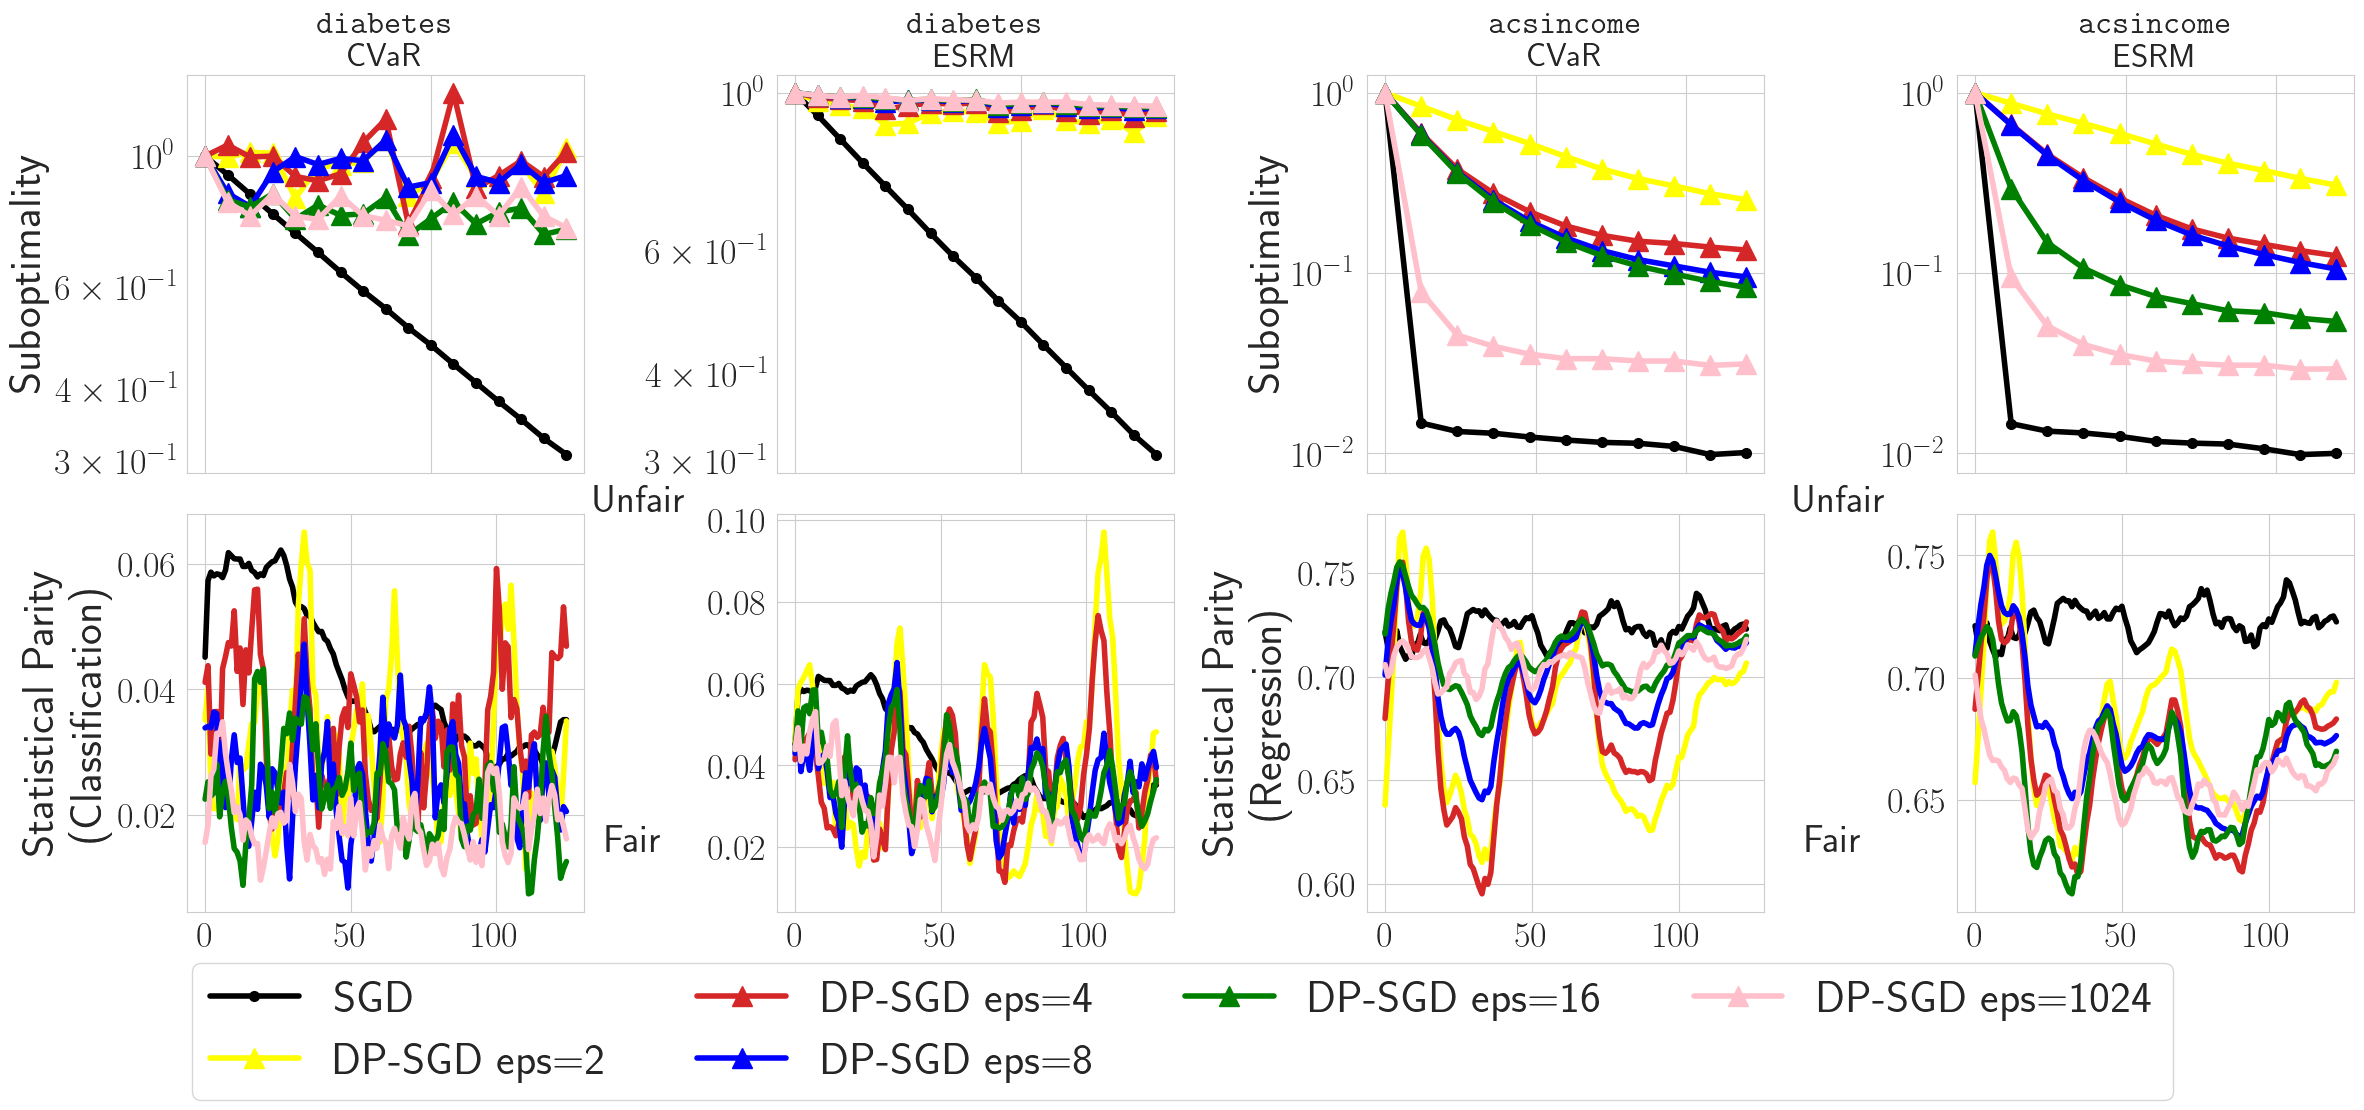

In [47]:
## demographic parity
from sklearn.preprocessing import LabelEncoder
dataset = "diabetes"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()

# print(X.shape)
# print(y.shape)

df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")
# print(df.gender.unique())
# print(df.race.unique())
# print(df.head)
# sex_tensor = torch.tensor(pd.get_dummies(df["gender"]).values, dtype=torch.float64)
# rac1p_tensor = torch.tensor(pd.get_dummies(df["race"]).values, dtype=torch.float64)

le_gender = LabelEncoder()
le_race = LabelEncoder()

gender_encoded = le_gender.fit_transform(df["gender"])
race_encoded = le_race.fit_transform(df["race"])

# Convert to tensors
gender_tensor = torch.tensor(gender_encoded, dtype=torch.float64).unsqueeze(1)
race_tensor = torch.tensor(race_encoded, dtype=torch.float64).unsqueeze(1)

# Concatenate the new attributes to X
X1 = torch.cat((X, gender_tensor, race_tensor), dim=1)

objectives = ["superquantile", "esrm"]
column = "gender"
metric = "difference"

sns.set_style("whitegrid")

fig, ax = plt.subplots(2, len(objectives) * 2, figsize=(12 * len(objectives), 10))

obj_names = ["CVaR", "ESRM", "CVaR", "ESRM"]
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        print(plot_cfg)
        epsilon = plot_cfg["epsilon"]
        # batch_size = plot_cfg["batch_size"]
        # path = os.path.join(base + f"_{float(epsilon):.6f}_{batch_size}")

        path = os.path.join(base + f"_{float(epsilon):.6f}")
        
        optimizer = plot_cfg["optimizer"]
        yy = get_dp(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, metric=metric,df=df,base_dir=path)
        xx = np.arange(len(yy))

        print(f"sp mean {optimizer}", np.array(yy)[-10:].mean())
        print(f"sp std {optimizer}", np.array(yy)[-10:].std())
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))


        markersize = 14
        downsample = 2
        ax[1, j].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        # ax[1, j].set_xticklabels([])
        ax[0, j].set_title(r"{\texttt{diabetes}}" + f"\n{obj_names[j]}", fontsize=24)

        
        plot_ax(ax[0, j], [1], objective, plot_cfg, dataset, max_epoch=32, downsample=downsample, markersize=markersize,out_path=path)
        ax[0, j].set_yscale("log")
        ax[0, j].set_xticklabels([])


ax[1, 0].set_ylabel("Statistical Parity\n(Classification)", fontsize=32)
ax[0, 0].set_ylabel(f"Suboptimality", fontsize=32)

# plt.show()
# acsincome

dataset = "acsincome"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()

print(X.shape)
print(y.shape)

df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")
print(df.SEX.unique())
print(df.RAC1P.unique())

objectives = ["superquantile", "esrm", "superquantile", "esrm"]
column = "RAC1P"
# metric = "ratio"
dataset = "acsincome"

obj_names = ["CVaR", "ESRM", "CVaR", "ESRM"]
for j, objective in enumerate(objectives):
    if j>1:
        for plot_cfg in plot_cfgs:
            epsilon = plot_cfg["epsilon"]
            # batch_size = plot_cfg["batch_size"]
            # path = os.path.join(base + f"_{float(epsilon):.6f}_{batch_size}")       
            path = os.path.join(base + f"_{float(epsilon):.6f}")

            optimizer = plot_cfg["optimizer"]
            group_loss = get_dist_groups(X,df,column, optimizer, objective,base_dir=path)
            yy = np.max(group_loss, axis=1) # worst distance
            xx = np.arange(len(yy))
            window_size = 5  # You can adjust the window size as needed
            yy_moving_avg = moving_average(yy, window_size)
            xx_moving_avg = np.arange(len(yy_moving_avg))

            markersize = 14
            downsample = 6
            ax[1, j].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
            # ax[1, j].set_xticklabels([])
            ax[0, j].set_title(r"{\texttt{acsincome}}" + f"\n{obj_names[j]}", fontsize=24)
            plot_ax(ax[0, j], [1], objective, plot_cfg, dataset, max_epoch=64, downsample=downsample, markersize=markersize,out_path=path)
            ax[0, j].set_yscale("log")
            ax[0, j].set_xticklabels([])


# # arrows
fig.text(0.26, 0.13, "Fair", fontsize=28)
fig.text(0.255, 0.47, "Unfair", fontsize=28)
fig.text(0.76, 0.13, "Fair", fontsize=28)
fig.text(0.755, 0.47, "Unfair", fontsize=28)

ax[1, 2].set_ylabel("Statistical Parity\n(Regression)", fontsize=32)
ax[0, 2].set_ylabel(f"Suboptimality", fontsize=32)
plt.tight_layout(pad=2.0)
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center',
            bbox_to_anchor=(0.5, -0.05), ncol=4)

plt.savefig(f"../figures/fairness_training_curves.pdf", bbox_inches="tight")
plt.show()

In [50]:
from fairlearn.metrics import equalized_odds_difference,equalized_odds_ratio

def get_equalized_odds(X,y,dataset,column, objective,optimizer, metric="difference",df=None,base_dir=None):
    iterates = get_iterates(dataset=dataset,objective=objective, optimizer=optimizer,result_dir=base_dir)
    out = []
    for i, w in tqdm(enumerate(iterates)):
        if i>=0:
            y_pred = (X @ w >= 0).int()
            if metric == "difference":
                out.append(equalized_odds_difference(y, y_pred, sensitive_features=list(df[column])))
            elif metric == "ratio":
                out.append(equalized_odds_ratio(y, y_pred, sensitive_features=list(df[column])))
    return out

{'optimizer': 'sgd', 'label': 'SGD', 'color': 'black', 'linestyle': 'solid', 'marker': '.', 'epsilon': 4}
objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:05, 21.54it/s]


sp mean sgd 0.058504958047292145
sp std sgd 0.007890590228634656
objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:06, 20.91it/s]


sp mean sgd 0.9160781417830289
sp std sgd 0.011298242050291316
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=2', 'color': 'yellow', 'linestyle': 'solid', 'marker': '^', 'epsilon': 2}
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:06, 20.84it/s]


sp mean dp_sgd 0.0754989369885019
sp std dp_sgd 0.0391173881512774
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:06, 21.18it/s]


sp mean dp_sgd 0.8375851759959048
sp std dp_sgd 0.07583081451715037
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=4', 'color': 'tab:red', 'linestyle': 'solid', 'marker': '^', 'epsilon': 4}
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:06, 20.95it/s]


sp mean dp_sgd 0.0674409634078981
sp std dp_sgd 0.024061254811973774
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:05, 23.06it/s]


sp mean dp_sgd 0.8558626058494674
sp std dp_sgd 0.04137491775710895
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=8', 'color': 'blue', 'linestyle': 'solid', 'marker': '^', 'epsilon': 8}
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:06, 20.16it/s]


sp mean dp_sgd 0.05415051139385378
sp std dp_sgd 0.02434984024988408
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:05, 22.56it/s]


sp mean dp_sgd 0.8848186889513683
sp std dp_sgd 0.05705076218907657
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=16', 'color': 'green', 'linestyle': 'solid', 'marker': '^', 'epsilon': 16}
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:05, 22.72it/s]


sp mean dp_sgd 0.04729674556175057
sp std dp_sgd 0.02528930628343223
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:07, 16.27it/s]


sp mean dp_sgd 0.9018285325415111
sp std dp_sgd 0.05158808704524196
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=1024', 'color': 'pink', 'linestyle': 'solid', 'marker': '^', 'epsilon': 1024}
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:04, 27.95it/s]


sp mean dp_sgd 0.07737440971426997
sp std dp_sgd 0.04139129679296583
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:04, 29.66it/s]


sp mean dp_sgd 0.8447729504124719
sp std dp_sgd 0.08436060968355191
{'optimizer': 'sgd', 'label': 'SGD', 'color': 'black', 'linestyle': 'solid', 'marker': '.', 'epsilon': 4}
objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:05, 22.47it/s]


sp mean sgd 0.058504958047292145
sp std sgd 0.007890590228634656
objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:05, 21.53it/s]


sp mean sgd 0.9160781417830289
sp std sgd 0.011298242050291316
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=2', 'color': 'yellow', 'linestyle': 'solid', 'marker': '^', 'epsilon': 2}
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:05, 23.47it/s]


sp mean dp_sgd 0.05424542382210691
sp std dp_sgd 0.02230359094742468
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:04, 28.35it/s]


sp mean dp_sgd 0.8510113000425171
sp std dp_sgd 0.05869008887683159
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=4', 'color': 'tab:red', 'linestyle': 'solid', 'marker': '^', 'epsilon': 4}
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:04, 26.27it/s]


sp mean dp_sgd 0.05280359499326075
sp std dp_sgd 0.03091291519987724
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:05, 24.50it/s]


sp mean dp_sgd 0.8022610962682076
sp std dp_sgd 0.07812062431663772
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=8', 'color': 'blue', 'linestyle': 'solid', 'marker': '^', 'epsilon': 8}
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:05, 25.70it/s]


sp mean dp_sgd 0.05130000548506235
sp std dp_sgd 0.01320314471140675
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:05, 22.03it/s]


sp mean dp_sgd 0.6008522417878305
sp std dp_sgd 0.1500382033253382
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=16', 'color': 'green', 'linestyle': 'solid', 'marker': '^', 'epsilon': 16}
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:05, 22.07it/s]


sp mean dp_sgd 0.039831590943937525
sp std dp_sgd 0.012609759712399702
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:06, 20.93it/s]


sp mean dp_sgd 0.5293477826847688
sp std dp_sgd 0.13008481012487674
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=1024', 'color': 'pink', 'linestyle': 'solid', 'marker': '^', 'epsilon': 1024}
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:05, 25.33it/s]


sp mean dp_sgd 0.028586852273478153
sp std dp_sgd 0.016710520962366908
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:04, 27.69it/s]


sp mean dp_sgd 0.39022785138544414
sp std dp_sgd 0.0988400658921354
torch.Size([1000, 202])
torch.Size([1000])
[1. 2.]
[1. 2. 9. 8. 7. 6. 5. 3.]
objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


0it [00:00, ?it/s]


ValueError: If pos_label is not specified, values must be from {0, 1} or {-1, 1}

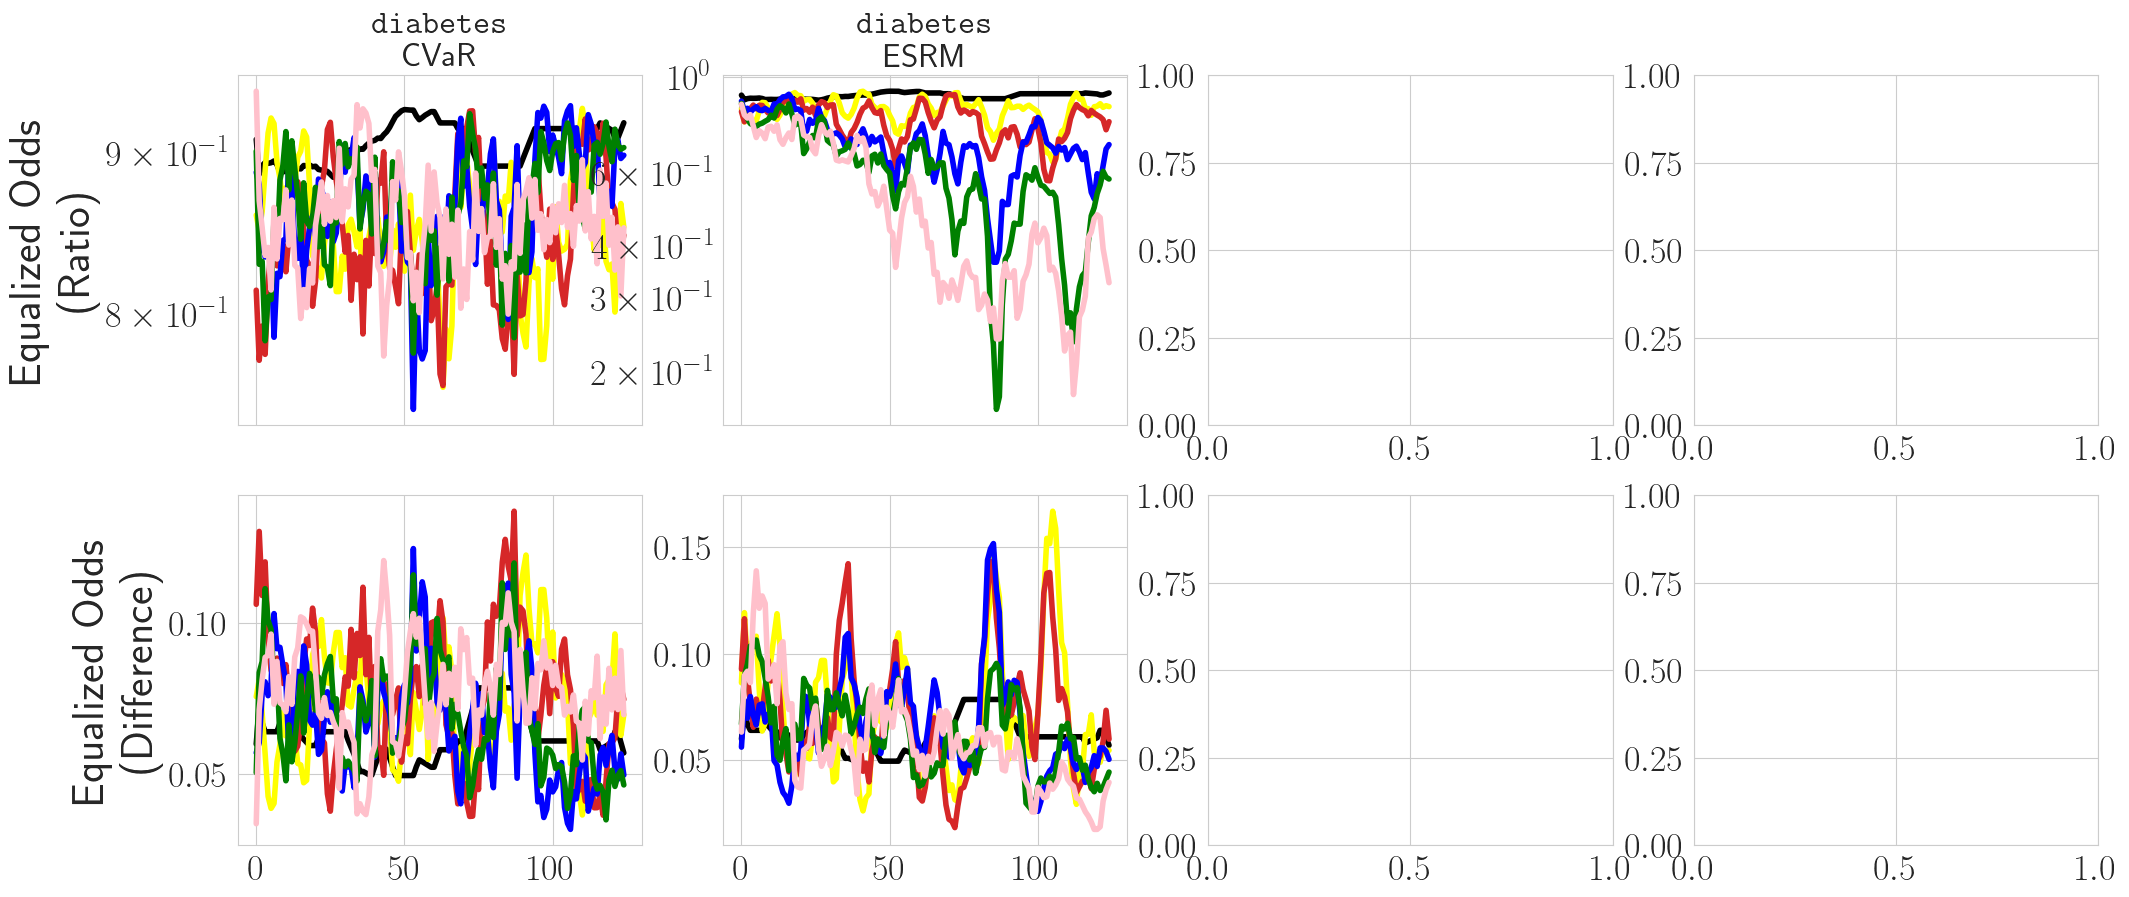

In [53]:
## demographic parity
from sklearn.preprocessing import LabelEncoder
dataset = "diabetes"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()

# print(X.shape)
# print(y.shape)

df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")
# print(df.gender.unique())
# print(df.race.unique())
# print(df.head)
# sex_tensor = torch.tensor(pd.get_dummies(df["gender"]).values, dtype=torch.float64)
# rac1p_tensor = torch.tensor(pd.get_dummies(df["race"]).values, dtype=torch.float64)

le_gender = LabelEncoder()
le_race = LabelEncoder()

gender_encoded = le_gender.fit_transform(df["gender"])
race_encoded = le_race.fit_transform(df["race"])

# Convert to tensors
gender_tensor = torch.tensor(gender_encoded, dtype=torch.float64).unsqueeze(1)
race_tensor = torch.tensor(race_encoded, dtype=torch.float64).unsqueeze(1)

# Concatenate the new attributes to X
X1 = torch.cat((X, gender_tensor, race_tensor), dim=1)

objectives = ["superquantile", "esrm"]
column = "gender"
metric = "difference"

sns.set_style("whitegrid")

fig, ax = plt.subplots(2, len(objectives) * 2, figsize=(12 * len(objectives), 10))

obj_names = ["CVaR", "ESRM", "CVaR", "ESRM"]
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        print(plot_cfg)
        epsilon = plot_cfg["epsilon"]
        # batch_size = plot_cfg["batch_size"]
        # path = os.path.join(base + f"_{float(epsilon):.6f}_{batch_size}")

        path = os.path.join(base + f"_{float(epsilon):.6f}")
        
        optimizer = plot_cfg["optimizer"]
        yy = get_equalized_odds(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, df=df,base_dir=path,metric="difference")
        xx = np.arange(len(yy))

        print(f"sp mean {optimizer}", np.array(yy)[-10:].mean())
        print(f"sp std {optimizer}", np.array(yy)[-10:].std())
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))


        markersize = 14
        downsample = 2
        ax[1, j].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        # ax[1, j].set_xticklabels([])
        ax[0, j].set_title(r"{\texttt{diabetes}}" + f"\n{obj_names[j]}", fontsize=24)

        yy = get_equalized_odds(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, df=df,base_dir=path,metric="ratio")
        xx = np.arange(len(yy))  
        print(f"sp mean {optimizer}", np.array(yy)[-10:].mean())
        print(f"sp std {optimizer}", np.array(yy)[-10:].std())
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))


        markersize = 14
        downsample = 2
        ax[0, j].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])      
        
        # plot_ax(ax[0, j], [1], objective, plot_cfg, dataset, max_epoch=32, downsample=downsample, markersize=markersize,out_path=path)
        ax[0, j].set_yscale("log")
        ax[0, j].set_xticklabels([])


ax[1, 0].set_ylabel("Equalized Odds\n(Difference)", fontsize=32)
ax[0, 0].set_ylabel(f"Equalized Odds\n(Ratio)", fontsize=32)

# plt.show()
# acsincome

dataset = "acsincome"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()

print(X.shape)
print(y.shape)

df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")
print(df.SEX.unique())
print(df.RAC1P.unique())

objectives = ["superquantile", "esrm", "superquantile", "esrm"]
column = "SEX"
# metric = "ratio"
dataset = "acsincome"

obj_names = ["CVaR", "ESRM", "CVaR", "ESRM"]
for j, objective in enumerate(objectives):
    if j>1:
        for plot_cfg in plot_cfgs:
            epsilon = plot_cfg["epsilon"]
            # batch_size = plot_cfg["batch_size"]
            # path = os.path.join(base + f"_{float(epsilon):.6f}_{batch_size}")       
            path = os.path.join(base + f"_{float(epsilon):.6f}")
            optimizer = plot_cfg["optimizer"]
            # group_loss = get_dist_groups(X,df,column, optimizer, objective,base_dir=path)
            
            yy = get_equalized_odds(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, df=df,base_dir=path,metric="difference")
            xx = np.arange(len(yy))

            print(f"sp mean {optimizer}", np.array(yy)[-10:].mean())
            print(f"sp std {optimizer}", np.array(yy)[-10:].std())
        
            window_size = 5  # You can adjust the window size as needed
            yy_moving_avg = moving_average(yy, window_size)
            xx_moving_avg = np.arange(len(yy_moving_avg))


            markersize = 14
            downsample = 2
            ax[1, j].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
            # ax[1, j].set_xticklabels([])
            ax[0, j].set_title(r"{\texttt{diabetes}}" + f"\n{obj_names[j]}", fontsize=24)

            yy = get_equalized_odds(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer,df=df,base_dir=path,metric="ratio")
            xx = np.arange(len(yy))  
            print(f"sp mean {optimizer}", np.array(yy)[-10:].mean())
            print(f"sp std {optimizer}", np.array(yy)[-10:].std())
        
            window_size = 5  # You can adjust the window size as needed
            yy_moving_avg = moving_average(yy, window_size)
            xx_moving_avg = np.arange(len(yy_moving_avg))


            markersize = 14
            downsample = 2
            ax[0, j].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])   
            # ax[1, j].set_xticklabels([])
            ax[0, j].set_title(r"{\texttt{acsincome}}" + f"\n{obj_names[j]}", fontsize=24)
            # plot_ax(ax[0, j], [1], objective, plot_cfg, dataset, max_epoch=64, downsample=downsample, markersize=markersize,out_path=path)
            ax[0, j].set_yscale("log")
            ax[0, j].set_xticklabels([])


# # arrows
# fig.text(0.26, 0.13, "Fair", fontsize=28)
# fig.text(0.255, 0.47, "Unfair", fontsize=28)
# fig.text(0.76, 0.13, "Fair", fontsize=28)
# fig.text(0.755, 0.47, "Unfair", fontsize=28)

# ax[1, 2].set_ylabel("Statistical Parity\n(Regression)", fontsize=32)
# ax[0, 2].set_ylabel(f"Suboptimality", fontsize=32)
ax[1, 2].set_ylabel("Equalized Odds\n(Difference)", fontsize=32)
ax[0, 2].set_ylabel(f"Equalized Odds\n(Ratio)", fontsize=32)
plt.tight_layout(pad=2.0)
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center',
            bbox_to_anchor=(0.5, -0.05), ncol=4)

plt.savefig(f"../figures/fairness_training_curves.pdf", bbox_inches="tight")
plt.show()

{'optimizer': 'sgd', 'label': 'SGD', 'color': 'black', 'linestyle': 'solid', 'marker': '.', 'epsilon': 4}
objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:07, 16.78it/s]


sp mean sgd 1.0
sp std sgd 0.0
objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:07, 18.11it/s]
/tmp/ipykernel_54254/2706771770.py:82: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[0, j].set_yscale("log")


sp mean sgd 0.0
sp std sgd 0.0
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=2', 'color': 'yellow', 'linestyle': 'solid', 'marker': '^', 'epsilon': 2}
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:07, 16.83it/s]


sp mean dp_sgd 0.85
sp std dp_sgd 0.22912878474779197
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:07, 18.23it/s]
/tmp/ipykernel_54254/2706771770.py:83: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[0, j].set_xticklabels([])


sp mean dp_sgd 0.0
sp std dp_sgd 0.0
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=4', 'color': 'tab:red', 'linestyle': 'solid', 'marker': '^', 'epsilon': 4}
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:06, 19.92it/s]


sp mean dp_sgd 0.809375
sp std dp_sgd 0.23371666800375573
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:07, 16.86it/s]
/tmp/ipykernel_54254/2706771770.py:83: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[0, j].set_xticklabels([])


sp mean dp_sgd 0.0
sp std dp_sgd 0.0
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=8', 'color': 'blue', 'linestyle': 'solid', 'marker': '^', 'epsilon': 8}
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:06, 20.08it/s]


sp mean dp_sgd 0.6683035714285714
sp std dp_sgd 0.27599689984836245
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:07, 18.38it/s]
/tmp/ipykernel_54254/2706771770.py:83: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[0, j].set_xticklabels([])


sp mean dp_sgd 0.0
sp std dp_sgd 0.0
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=16', 'color': 'green', 'linestyle': 'solid', 'marker': '^', 'epsilon': 16}
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:06, 20.63it/s]


sp mean dp_sgd 0.8007264957264957
sp std dp_sgd 0.2565246219309264
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:07, 17.06it/s]
/tmp/ipykernel_54254/2706771770.py:83: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[0, j].set_xticklabels([])


sp mean dp_sgd 0.0
sp std dp_sgd 0.0
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=1024', 'color': 'pink', 'linestyle': 'solid', 'marker': '^', 'epsilon': 1024}
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:06, 20.10it/s]


sp mean dp_sgd 0.8597252747252746
sp std dp_sgd 0.2149662411748075
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:07, 17.15it/s]
/tmp/ipykernel_54254/2706771770.py:83: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[0, j].set_xticklabels([])


sp mean dp_sgd 0.0
sp std dp_sgd 0.0
{'optimizer': 'sgd', 'label': 'SGD', 'color': 'black', 'linestyle': 'solid', 'marker': '.', 'epsilon': 4}
objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:07, 18.21it/s]


sp mean sgd 1.0
sp std sgd 0.0
objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:05, 24.45it/s]
/tmp/ipykernel_54254/2706771770.py:82: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[0, j].set_yscale("log")


sp mean sgd 0.0
sp std sgd 0.0
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=2', 'color': 'yellow', 'linestyle': 'solid', 'marker': '^', 'epsilon': 2}
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:04, 28.15it/s]


sp mean dp_sgd 0.9354166666666668
sp std dp_sgd 0.19374999999999998
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:05, 22.07it/s]
/tmp/ipykernel_54254/2706771770.py:83: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[0, j].set_xticklabels([])


sp mean dp_sgd 0.0
sp std dp_sgd 0.0
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=4', 'color': 'tab:red', 'linestyle': 'solid', 'marker': '^', 'epsilon': 4}
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:05, 22.72it/s]


sp mean dp_sgd 0.7846428571428572
sp std dp_sgd 0.3293625956112125
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:05, 23.45it/s]
/tmp/ipykernel_54254/2706771770.py:83: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[0, j].set_xticklabels([])


sp mean dp_sgd 0.0
sp std dp_sgd 0.0
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=8', 'color': 'blue', 'linestyle': 'solid', 'marker': '^', 'epsilon': 8}
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:05, 24.90it/s]


sp mean dp_sgd 0.3573851650116101
sp std dp_sgd 0.32219609097630464
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:06, 18.52it/s]
/tmp/ipykernel_54254/2706771770.py:83: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[0, j].set_xticklabels([])


sp mean dp_sgd 0.0
sp std dp_sgd 0.0
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=16', 'color': 'green', 'linestyle': 'solid', 'marker': '^', 'epsilon': 16}
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:04, 28.66it/s]


sp mean dp_sgd 0.1983760683760684
sp std dp_sgd 0.013952582420936192
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:06, 19.99it/s]
/tmp/ipykernel_54254/2706771770.py:83: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[0, j].set_xticklabels([])


sp mean dp_sgd 0.0
sp std dp_sgd 0.0
{'optimizer': 'dp_sgd', 'label': 'DP-SGD eps=1024', 'color': 'pink', 'linestyle': 'solid', 'marker': '^', 'epsilon': 1024}
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:06, 20.13it/s]


sp mean dp_sgd 0.2
sp std dp_sgd 0.0
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:04, 27.45it/s]
/tmp/ipykernel_54254/2706771770.py:83: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[0, j].set_xticklabels([])


sp mean dp_sgd 0.0
sp std dp_sgd 0.0
torch.Size([1000, 202])
torch.Size([1000])
[1. 2.]
[1. 2. 9. 8. 7. 6. 5. 3.]
objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


0it [00:00, ?it/s]


ValueError: If pos_label is not specified, values must be from {0, 1} or {-1, 1}

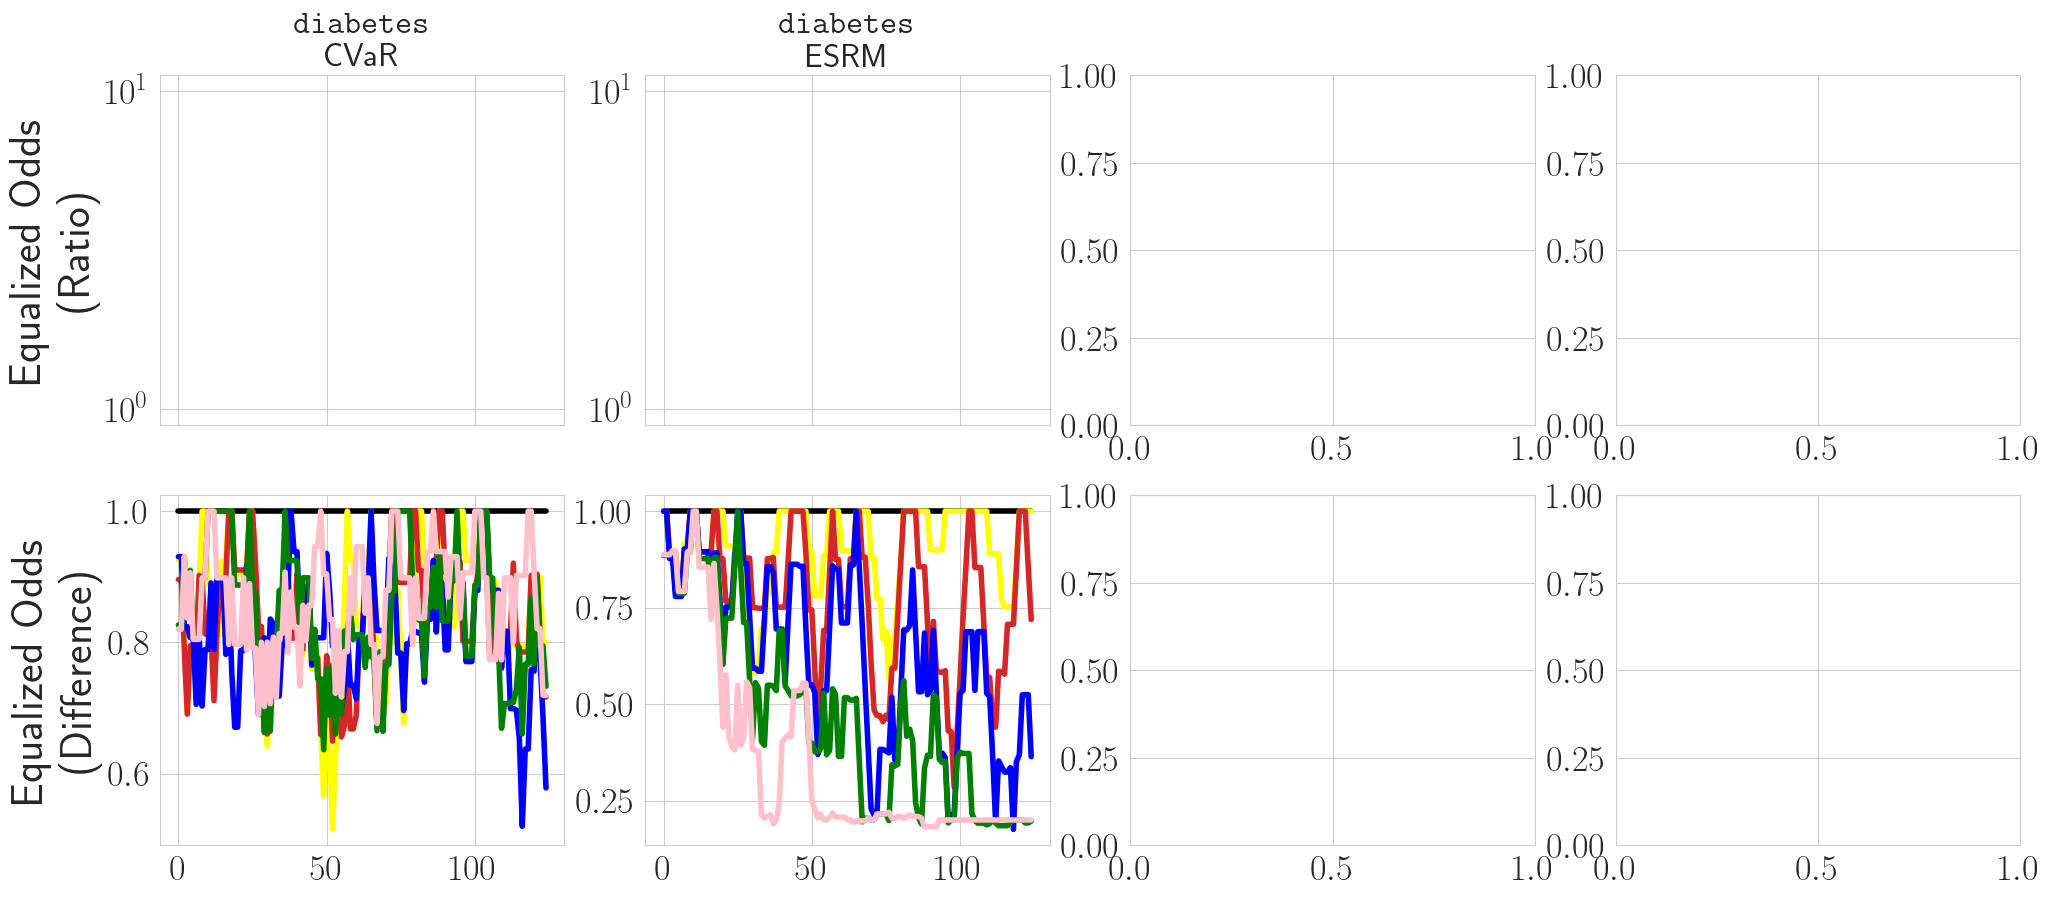

In [54]:
## demographic parity
from sklearn.preprocessing import LabelEncoder
dataset = "diabetes"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()

# print(X.shape)
# print(y.shape)

df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")
# print(df.gender.unique())
# print(df.race.unique())
# print(df.head)
# sex_tensor = torch.tensor(pd.get_dummies(df["gender"]).values, dtype=torch.float64)
# rac1p_tensor = torch.tensor(pd.get_dummies(df["race"]).values, dtype=torch.float64)

le_gender = LabelEncoder()
le_race = LabelEncoder()

gender_encoded = le_gender.fit_transform(df["gender"])
race_encoded = le_race.fit_transform(df["race"])

# Convert to tensors
gender_tensor = torch.tensor(gender_encoded, dtype=torch.float64).unsqueeze(1)
race_tensor = torch.tensor(race_encoded, dtype=torch.float64).unsqueeze(1)

# Concatenate the new attributes to X
X1 = torch.cat((X, gender_tensor, race_tensor), dim=1)

objectives = ["superquantile", "esrm"]
column = "race"
metric = "difference"

sns.set_style("whitegrid")

fig, ax = plt.subplots(2, len(objectives) * 2, figsize=(12 * len(objectives), 10))

obj_names = ["CVaR", "ESRM", "CVaR", "ESRM"]
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        print(plot_cfg)
        epsilon = plot_cfg["epsilon"]
        # batch_size = plot_cfg["batch_size"]
        # path = os.path.join(base + f"_{float(epsilon):.6f}_{batch_size}")

        path = os.path.join(base + f"_{float(epsilon):.6f}")
        
        optimizer = plot_cfg["optimizer"]
        yy = get_equalized_odds(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, df=df,base_dir=path,metric="difference")
        xx = np.arange(len(yy))

        print(f"sp mean {optimizer}", np.array(yy)[-10:].mean())
        print(f"sp std {optimizer}", np.array(yy)[-10:].std())
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))


        markersize = 14
        downsample = 2
        ax[1, j].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        # ax[1, j].set_xticklabels([])
        ax[0, j].set_title(r"{\texttt{diabetes}}" + f"\n{obj_names[j]}", fontsize=24)

        yy = get_equalized_odds(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, df=df,base_dir=path,metric="ratio")
        xx = np.arange(len(yy))  
        print(f"sp mean {optimizer}", np.array(yy)[-10:].mean())
        print(f"sp std {optimizer}", np.array(yy)[-10:].std())
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))


        markersize = 14
        downsample = 2
        ax[0, j].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])      
        
        # plot_ax(ax[0, j], [1], objective, plot_cfg, dataset, max_epoch=32, downsample=downsample, markersize=markersize,out_path=path)
        ax[0, j].set_yscale("log")
        ax[0, j].set_xticklabels([])


ax[1, 0].set_ylabel("Equalized Odds\n(Difference)", fontsize=32)
ax[0, 0].set_ylabel(f"Equalized Odds\n(Ratio)", fontsize=32)

# plt.show()
# acsincome

dataset = "acsincome"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()

print(X.shape)
print(y.shape)

df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")
print(df.SEX.unique())
print(df.RAC1P.unique())

objectives = ["superquantile", "esrm", "superquantile", "esrm"]
column = "RAC1P"
# metric = "ratio"
dataset = "acsincome"

obj_names = ["CVaR", "ESRM", "CVaR", "ESRM"]
for j, objective in enumerate(objectives):
    if j>1:
        for plot_cfg in plot_cfgs:
            epsilon = plot_cfg["epsilon"]
            # batch_size = plot_cfg["batch_size"]
            # path = os.path.join(base + f"_{float(epsilon):.6f}_{batch_size}")       
            path = os.path.join(base + f"_{float(epsilon):.6f}")
            optimizer = plot_cfg["optimizer"]
            # group_loss = get_dist_groups(X,df,column, optimizer, objective,base_dir=path)
            
            yy = get_equalized_odds(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, df=df,base_dir=path,metric="difference")
            xx = np.arange(len(yy))

            print(f"sp mean {optimizer}", np.array(yy)[-10:].mean())
            print(f"sp std {optimizer}", np.array(yy)[-10:].std())
        
            window_size = 5  # You can adjust the window size as needed
            yy_moving_avg = moving_average(yy, window_size)
            xx_moving_avg = np.arange(len(yy_moving_avg))


            markersize = 14
            downsample = 2
            ax[1, j].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
            # ax[1, j].set_xticklabels([])
            ax[0, j].set_title(r"{\texttt{diabetes}}" + f"\n{obj_names[j]}", fontsize=24)

            yy = get_equalized_odds(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer,df=df,base_dir=path,metric="ratio")
            xx = np.arange(len(yy))  
            print(f"sp mean {optimizer}", np.array(yy)[-10:].mean())
            print(f"sp std {optimizer}", np.array(yy)[-10:].std())
        
            window_size = 5  # You can adjust the window size as needed
            yy_moving_avg = moving_average(yy, window_size)
            xx_moving_avg = np.arange(len(yy_moving_avg))


            markersize = 14
            downsample = 2
            ax[0, j].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])   
            # ax[1, j].set_xticklabels([])
            ax[0, j].set_title(r"{\texttt{acsincome}}" + f"\n{obj_names[j]}", fontsize=24)
            # plot_ax(ax[0, j], [1], objective, plot_cfg, dataset, max_epoch=64, downsample=downsample, markersize=markersize,out_path=path)
            ax[0, j].set_yscale("log")
            ax[0, j].set_xticklabels([])


# # arrows
# fig.text(0.26, 0.13, "Fair", fontsize=28)
# fig.text(0.255, 0.47, "Unfair", fontsize=28)
# fig.text(0.76, 0.13, "Fair", fontsize=28)
# fig.text(0.755, 0.47, "Unfair", fontsize=28)

# ax[1, 2].set_ylabel("Statistical Parity\n(Regression)", fontsize=32)
# ax[0, 2].set_ylabel(f"Suboptimality", fontsize=32)
ax[1, 2].set_ylabel("Equalized Odds\n(Difference)", fontsize=32)
ax[0, 2].set_ylabel(f"Equalized Odds\n(Ratio)", fontsize=32)
plt.tight_layout(pad=2.0)
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center',
            bbox_to_anchor=(0.5, -0.05), ncol=4)

plt.savefig(f"../figures/fairness_training_curves.pdf", bbox_inches="tight")
plt.show()